# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 

Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm

In [2]:
!nvidia-smi

Mon Mar 20 22:30:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [5]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [6]:
testset, trainset

(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ), Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

## Data Preprocessing

In [7]:
BATCH_SIZE = 8
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

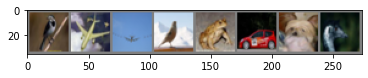

bird  plane plane bird  frog  car   dog   bird 


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


## Model

In [18]:
# Parameters 


N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

In [19]:
class Backbone(nn.Module):

  def __init__(self, img_size=IMG_DIM, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
    super(Backbone, self).__init__()

    # Boolean to print debug logs.
    self.debug = debug

    self.spaitial_average_pool = nn.AvgPool2d(kernel_size=img_size)
    self.linear = nn.Sequential(
        nn.Linear(in_features=in_channels, out_features=k, bias=False),   # Question, can this be MLP?
        #nn.Tanh(),
        # nn.LeakyReLU(),
        # nn.Linear(in_features=k, out_features=k, bias=True),  
        # nn.ReLU(),
        nn.Sigmoid(),      # Non Linear Activation
    )
    # self.non_linear = nn.Sigmoid()       # Non Linear Activation
    # self.non_linear = nn.ReLU()

    self.conv2ds = nn.ModuleList([
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        for _ in range(k)
    ])

  def forward(self, x):
    sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"{sap_out.shape=}")

    g_out = self.linear(sap_out)
    #if self.debug: print(f"{lin_out.shape=}")

    #g_out = self.non_linear(lin_out)
    if self.debug: print(f"{g_out.shape=}")
    if self.debug: print(f"{g_out=}")

    outs = list()
    for a, conv2d in zip(g_out.transpose(0, 1), self.conv2ds):
      c_out = conv2d(x)
      if self.debug: print(f"{c_out.shape=}")
      if self.debug: print(f"{a.shape=}, \n{a=}")

      out = a.reshape(x.shape[0], 1, 1, 1)*c_out
      if self.debug: print(f"{out.shape=}")
      outs.append(out)
      
    out = sum(outs)
    if self.debug: print(f"{out.shape=}")

    return out

  def set_device_to(self, device='cuda'):
    if 'cuda' == device and not torch.cuda.is_available():
      print(f"Cuda not available")
      return

    self.spaitial_average_pool.to(device)
    self.linear.to(device)
    self.non_linear.to(device)

    for conv2d in self.conv2ds:
      conv2d.to(device)

In [20]:
class Model(nn.Module):

  def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
    super(Model, self).__init__()

    # Boolean to print debug logs.
    self.debug = debug
    self.Ks = Ks
    self.channels = channels
    self.img_sizes = [IMG_DIM + (STRIDE-kernel_size)*i for i in range(n+1)]

    if self.debug: print(f"{self.channels=}")
    if self.debug: print(f"{self.img_sizes=}")
    if self.debug: print(f"{self.Ks=}")
    if self.debug: print(f"{n=}")

    self.backbones = nn.ModuleList([
        Backbone(
            img_size=self.img_sizes[i], 
            in_channels=self.channels[i], 
            out_channels=self.channels[i+1], 
            kernel_size=kernel_size, 
            k=self.Ks[i], 
            debug=debug
        ) 
        for i in range(n)
    ])

    self.spaitial_average_pool = nn.AvgPool2d(kernel_size=self.img_sizes[-1])
    self.linear = nn.Sequential(
        # nn.Linear(in_features=self.channels[-1], out_features=self.channels[-1] * 2 // 3, bias=False),
        # nn.Dropout(p=0.2),
        # nn.ReLU(),
        # nn.Linear(in_features=self.channels[-1] * 2 // 3, out_features=self.channels[-1] // 3, bias=False),
        # nn.Dropout(p=0.2),
        # nn.ReLU(),
        # nn.Linear(in_features=self.channels[-1] // 3, out_features=len(CLASSES), bias=False),
        nn.Linear(in_features=self.channels[-1], out_features=len(CLASSES), bias=False),
    )
    # self.linear = nn.Linear(in_features=self.channels[-1], out_features=len(CLASSES), bias=False)

  def set_debug(self, debug=True):
    self.debug = debug
    for backbone in self.backbones:
      backbone.debug = debug

  def forward(self, x):
    for backbone in self.backbones:
      x = backbone(x)
    
    f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"M: {f.shape=}")

    out = self.linear(f)
    if self.debug: print(f"M: {out.shape=}")

    return out

In [21]:
class Trainer:

  def __init__(self, model, criterion, optimizer, epochs, trainloader, testloader, logs_per_epoch=4) -> None:
    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    
    self.epochs = epochs
    self.log_step = len(trainloader) // logs_per_epoch

    self.trainloader = trainloader
    self.testloader = testloader

    self.losses = list()
    self.val_losses = list()
    self.batch_losses = list()
    
    self.val_accuracy = list()

  def train(self, use_gpu=False):

    for epoch in range(self.epochs):  # loop over the dataset multiple times

        batch_losses = list()
        running_loss = 0.0
        for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if use_gpu:
              inputs = inputs.to('cuda')
              labels = labels.to('cuda')
            
            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            # print statistics
            batch_losses.append(loss.item())
            running_loss += loss.item()
            if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                avg_loss = running_loss / self.log_step
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                running_loss = 0.0
                self.batch_losses.append(avg_loss)

        self.losses.append(sum(batch_losses) / len(batch_losses))

        print(f"Train Loss : {self.losses[-1]}")
        self.eval()

    print('Finished Training')

  def eval(self):
    correct = 0
    total = 0
    losses = list()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in self.testloader:
            images, labels = data
            if USE_GPU:
              images = images.to('cuda')
              labels = labels.to('cuda')

            # calculate outputs by running images through the network
            outputs = self.model(images)

            loss = self.criterion(outputs, labels)
            losses.append(loss.item())

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
    val_loss = sum(losses) / len(losses)
    self.val_losses.append(val_loss)

    print(f"Val Loss : {val_loss}")
    
    accuracy = correct / total
    self.val_accuracy.append(accuracy)
    print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
    
  def plot(self):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 3)

    X = np.linspace(0, len(self.losses)-1, len(self.batch_losses))
    ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', marker='x', linestyle='dashed', lw=1, alpha=0.7)
    ax1.plot(self.losses, label='Train', color='C0', marker='o', lw=3, alpha=1)
    ax1.plot(self.val_losses, label='Test', color='C1', marker='o', lw=3, alpha=1)
    ax1.legend()
    ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
    
    ax2.plot(self.val_accuracy, label="Test", color='C1', marker='o', lw=3, alpha=1)
    ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
    plt.tight_layout()
    fig.show()
    

In [22]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [23]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 7
STRIDE = 1

# channels = [IMG_CHANNELS, 16, 32, 64, 64] #20, 25, 30]
# channels = [IMG_CHANNELS, 4, 8, 16, ]
# channels = [IMG_CHANNELS, 5, 7, 9, 11, 13]
channels = [IMG_CHANNELS, 5, 7, 9, 11]
# Ks = channels[1:]
Ks = [5] * (len(channels) - 1)
N = len(channels) - 1

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)

if USE_GPU: model.to('cuda')


model

self.channels=[3, 5, 7, 9, 11]
self.img_sizes=[32, 26, 20, 14, 8]
self.Ks=[5, 5, 5, 5]
n=4


Model(
  (backbones): ModuleList(
    (0): Backbone(
      (spaitial_average_pool): AvgPool2d(kernel_size=32, stride=32, padding=0)
      (linear): Sequential(
        (0): Linear(in_features=3, out_features=5, bias=False)
        (1): Sigmoid()
      )
      (conv2ds): ModuleList(
        (0): Conv2d(3, 5, kernel_size=(7, 7), stride=(1, 1))
        (1): Conv2d(3, 5, kernel_size=(7, 7), stride=(1, 1))
        (2): Conv2d(3, 5, kernel_size=(7, 7), stride=(1, 1))
        (3): Conv2d(3, 5, kernel_size=(7, 7), stride=(1, 1))
        (4): Conv2d(3, 5, kernel_size=(7, 7), stride=(1, 1))
      )
    )
    (1): Backbone(
      (spaitial_average_pool): AvgPool2d(kernel_size=26, stride=26, padding=0)
      (linear): Sequential(
        (0): Linear(in_features=5, out_features=5, bias=False)
        (1): Sigmoid()
      )
      (conv2ds): ModuleList(
        (0): Conv2d(5, 7, kernel_size=(7, 7), stride=(1, 1))
        (1): Conv2d(5, 7, kernel_size=(7, 7), stride=(1, 1))
        (2): Conv2d(5, 7, k

In [24]:
# Init optimizer 

LR = 1e-3 #1e-3, 1e-4
MOMENTUM = 0.9 #0.9


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

model.set_debug(False)

In [25]:
# Init Trainer

EPOCHS = 3
BATCH_SIZE = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=EPOCHS, 
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

  0%|          | 0/782 [00:00<?, ?it/s]

[1,   195] loss: 2.005
[1,   390] loss: 1.910
[1,   585] loss: 1.846
[1,   780] loss: 1.819
Train Loss : 1.8947148913007867
Val Loss : 1.7923996273879033
Accuracy of the network on the 10000 test images: 35.75 %


  0%|          | 0/782 [00:00<?, ?it/s]

[2,   195] loss: 1.797
[2,   390] loss: 1.796
[2,   585] loss: 1.762
[2,   780] loss: 1.747
Train Loss : 1.7761392096424347
Val Loss : 1.7295703751266382
Accuracy of the network on the 10000 test images: 39.37 %


  0%|          | 0/782 [00:00<?, ?it/s]

[3,   195] loss: 1.739
[3,   390] loss: 1.741
[3,   585] loss: 1.733
[3,   780] loss: 1.709
Train Loss : 1.7306575076964201
Val Loss : 1.7282789467246669
Accuracy of the network on the 10000 test images: 37.61 %


  0%|          | 0/782 [00:00<?, ?it/s]

[4,   195] loss: 1.710
[4,   390] loss: 1.685
[4,   585] loss: 1.660
[4,   780] loss: 1.680
Train Loss : 1.6833521900579447
Val Loss : 1.6557745591850037
Accuracy of the network on the 10000 test images: 41.00 %


  0%|          | 0/782 [00:00<?, ?it/s]

[5,   195] loss: 1.662
[5,   390] loss: 1.664
[5,   585] loss: 1.655
[5,   780] loss: 1.627
Train Loss : 1.6525343935507948
Val Loss : 1.6110178330901321
Accuracy of the network on the 10000 test images: 42.92 %


  0%|          | 0/782 [00:00<?, ?it/s]

[6,   195] loss: 1.636
[6,   390] loss: 1.631
[6,   585] loss: 1.626
[6,   780] loss: 1.617
Train Loss : 1.627190233801332
Val Loss : 1.617769820674969
Accuracy of the network on the 10000 test images: 43.23 %


  0%|          | 0/782 [00:00<?, ?it/s]

[7,   195] loss: 1.605
[7,   390] loss: 1.626
[7,   585] loss: 1.603
[7,   780] loss: 1.600
Train Loss : 1.6089888702877952
Val Loss : 1.6143308969060326
Accuracy of the network on the 10000 test images: 42.91 %


  0%|          | 0/782 [00:00<?, ?it/s]

[8,   195] loss: 1.587
[8,   390] loss: 1.589
[8,   585] loss: 1.588
[8,   780] loss: 1.597
Train Loss : 1.5897259646669373
Val Loss : 1.6235342314288874
Accuracy of the network on the 10000 test images: 44.01 %


  0%|          | 0/782 [00:00<?, ?it/s]

[9,   195] loss: 1.582
[9,   390] loss: 1.575
[9,   585] loss: 1.564
[9,   780] loss: 1.586
Train Loss : 1.576697151374329
Val Loss : 1.5823138253703999
Accuracy of the network on the 10000 test images: 43.83 %


  0%|          | 0/782 [00:00<?, ?it/s]

[10,   195] loss: 1.562
[10,   390] loss: 1.562
[10,   585] loss: 1.569
[10,   780] loss: 1.572
Train Loss : 1.5665476886207794
Val Loss : 1.5818562135574923
Accuracy of the network on the 10000 test images: 44.14 %


  0%|          | 0/782 [00:00<?, ?it/s]

[11,   195] loss: 1.553
[11,   390] loss: 1.543
[11,   585] loss: 1.570
[11,   780] loss: 1.565
Train Loss : 1.5574786824643458
Val Loss : 1.5626138069067792
Accuracy of the network on the 10000 test images: 44.66 %


  0%|          | 0/782 [00:00<?, ?it/s]

[12,   195] loss: 1.541
[12,   390] loss: 1.552
[12,   585] loss: 1.552
[12,   780] loss: 1.552
Train Loss : 1.5485973038027048
Val Loss : 1.5606431930687776
Accuracy of the network on the 10000 test images: 45.18 %


  0%|          | 0/782 [00:00<?, ?it/s]

[13,   195] loss: 1.528
[13,   390] loss: 1.556
[13,   585] loss: 1.536
[13,   780] loss: 1.544
Train Loss : 1.541067040332443
Val Loss : 1.5555097904934245
Accuracy of the network on the 10000 test images: 45.21 %


  0%|          | 0/782 [00:00<?, ?it/s]

[14,   195] loss: 1.540
[14,   390] loss: 1.521
[14,   585] loss: 1.539
[14,   780] loss: 1.532
Train Loss : 1.5329460946800153
Val Loss : 1.5512990146685557
Accuracy of the network on the 10000 test images: 45.31 %


  0%|          | 0/782 [00:00<?, ?it/s]

[15,   195] loss: 1.521
[15,   390] loss: 1.526
[15,   585] loss: 1.525
[15,   780] loss: 1.521
Train Loss : 1.5233562146611226
Val Loss : 1.5382436567051396
Accuracy of the network on the 10000 test images: 46.30 %


  0%|          | 0/782 [00:00<?, ?it/s]

[16,   195] loss: 1.513
[16,   390] loss: 1.521
[16,   585] loss: 1.520
[16,   780] loss: 1.522
Train Loss : 1.519174375040147
Val Loss : 1.5429089524943358
Accuracy of the network on the 10000 test images: 45.59 %


  0%|          | 0/782 [00:00<?, ?it/s]

[17,   195] loss: 1.515
[17,   390] loss: 1.512
[17,   585] loss: 1.511
[17,   780] loss: 1.508
Train Loss : 1.5115868007130635
Val Loss : 1.574136429531559
Accuracy of the network on the 10000 test images: 44.30 %


  0%|          | 0/782 [00:00<?, ?it/s]

[18,   195] loss: 1.508
[18,   390] loss: 1.500
[18,   585] loss: 1.517
[18,   780] loss: 1.515
Train Loss : 1.5105056434945987
Val Loss : 1.519390188964309
Accuracy of the network on the 10000 test images: 46.65 %


  0%|          | 0/782 [00:00<?, ?it/s]

[19,   195] loss: 1.494
[19,   390] loss: 1.516
[19,   585] loss: 1.503
[19,   780] loss: 1.501
Train Loss : 1.503543686531389
Val Loss : 1.5362082636280425
Accuracy of the network on the 10000 test images: 46.03 %


  0%|          | 0/782 [00:00<?, ?it/s]

[20,   195] loss: 1.496
[20,   390] loss: 1.499
[20,   585] loss: 1.518
[20,   780] loss: 1.498
Train Loss : 1.5026292741451117
Val Loss : 1.5286356840923334
Accuracy of the network on the 10000 test images: 46.94 %


  0%|          | 0/782 [00:00<?, ?it/s]

[21,   195] loss: 1.490
[21,   390] loss: 1.504
[21,   585] loss: 1.489
[21,   780] loss: 1.495
Train Loss : 1.4948668960110305
Val Loss : 1.5419509600681864
Accuracy of the network on the 10000 test images: 46.23 %


  0%|          | 0/782 [00:00<?, ?it/s]

[22,   195] loss: 1.497
[22,   390] loss: 1.494
[22,   585] loss: 1.480
[22,   780] loss: 1.501
Train Loss : 1.4928397429568687
Val Loss : 1.521619308526349
Accuracy of the network on the 10000 test images: 46.60 %


  0%|          | 0/782 [00:00<?, ?it/s]

[23,   195] loss: 1.477
[23,   390] loss: 1.483
[23,   585] loss: 1.493
[23,   780] loss: 1.501
Train Loss : 1.4879620985301865
Val Loss : 1.5073671348535331
Accuracy of the network on the 10000 test images: 47.33 %


  0%|          | 0/782 [00:00<?, ?it/s]

[24,   195] loss: 1.489
[24,   390] loss: 1.489
[24,   585] loss: 1.478
[24,   780] loss: 1.489
Train Loss : 1.4860684214650517
Val Loss : 1.5082372434579643
Accuracy of the network on the 10000 test images: 47.50 %


  0%|          | 0/782 [00:00<?, ?it/s]

[25,   195] loss: 1.475
[25,   390] loss: 1.479
[25,   585] loss: 1.495
[25,   780] loss: 1.484
Train Loss : 1.483514868694803
Val Loss : 1.5045706868930986
Accuracy of the network on the 10000 test images: 46.78 %


  0%|          | 0/782 [00:00<?, ?it/s]

[26,   195] loss: 1.459
[26,   390] loss: 1.497
[26,   585] loss: 1.472
[26,   780] loss: 1.495
Train Loss : 1.4806039952256185
Val Loss : 1.5041408948837571
Accuracy of the network on the 10000 test images: 47.51 %


  0%|          | 0/782 [00:00<?, ?it/s]

[27,   195] loss: 1.458
[27,   390] loss: 1.479
[27,   585] loss: 1.460
[27,   780] loss: 1.486
Train Loss : 1.4706486742514784
Val Loss : 1.5437605183595304
Accuracy of the network on the 10000 test images: 45.86 %


  0%|          | 0/782 [00:00<?, ?it/s]

[28,   195] loss: 1.470
[28,   390] loss: 1.469
[28,   585] loss: 1.474
[28,   780] loss: 1.465
Train Loss : 1.4693628753847479
Val Loss : 1.5056858510728095
Accuracy of the network on the 10000 test images: 47.40 %


  0%|          | 0/782 [00:00<?, ?it/s]

[29,   195] loss: 1.455
[29,   390] loss: 1.480
[29,   585] loss: 1.470
[29,   780] loss: 1.472
Train Loss : 1.4692380570084846
Val Loss : 1.525935239093319
Accuracy of the network on the 10000 test images: 46.65 %


  0%|          | 0/782 [00:00<?, ?it/s]

[30,   195] loss: 1.462
[30,   390] loss: 1.459
[30,   585] loss: 1.480
[30,   780] loss: 1.462
Train Loss : 1.466215607607761
Val Loss : 1.5252282763742337
Accuracy of the network on the 10000 test images: 46.43 %


  0%|          | 0/782 [00:00<?, ?it/s]

[31,   195] loss: 1.462
[31,   390] loss: 1.472
[31,   585] loss: 1.457
[31,   780] loss: 1.468
Train Loss : 1.464519545092912
Val Loss : 1.498758831601234
Accuracy of the network on the 10000 test images: 46.70 %


  0%|          | 0/782 [00:00<?, ?it/s]

[32,   195] loss: 1.444
[32,   390] loss: 1.468
[32,   585] loss: 1.448
[32,   780] loss: 1.465
Train Loss : 1.4562889200342282
Val Loss : 1.4956478434763136
Accuracy of the network on the 10000 test images: 47.61 %


  0%|          | 0/782 [00:00<?, ?it/s]

[33,   195] loss: 1.446
[33,   390] loss: 1.469
[33,   585] loss: 1.446
[33,   780] loss: 1.456
Train Loss : 1.4547282911627495
Val Loss : 1.5062552629762394
Accuracy of the network on the 10000 test images: 46.83 %


  0%|          | 0/782 [00:00<?, ?it/s]

[34,   195] loss: 1.445
[34,   390] loss: 1.464
[34,   585] loss: 1.454
[34,   780] loss: 1.459
Train Loss : 1.455939748250615
Val Loss : 1.5048717305918409
Accuracy of the network on the 10000 test images: 46.90 %


  0%|          | 0/782 [00:00<?, ?it/s]

[35,   195] loss: 1.437
[35,   390] loss: 1.436
[35,   585] loss: 1.456
[35,   780] loss: 1.471
Train Loss : 1.449937586741679
Val Loss : 1.4917554263096706
Accuracy of the network on the 10000 test images: 47.50 %


  0%|          | 0/782 [00:00<?, ?it/s]

[36,   195] loss: 1.456
[36,   390] loss: 1.447
[36,   585] loss: 1.458
[36,   780] loss: 1.437
Train Loss : 1.4492418647117322
Val Loss : 1.5394100748049986
Accuracy of the network on the 10000 test images: 46.66 %


  0%|          | 0/782 [00:00<?, ?it/s]

[37,   195] loss: 1.437
[37,   390] loss: 1.464
[37,   585] loss: 1.446
[37,   780] loss: 1.442
Train Loss : 1.4468488225241756
Val Loss : 1.5167959548865155
Accuracy of the network on the 10000 test images: 47.47 %


  0%|          | 0/782 [00:00<?, ?it/s]

[38,   195] loss: 1.444
[38,   390] loss: 1.421
[38,   585] loss: 1.445
[38,   780] loss: 1.466
Train Loss : 1.44366534119067
Val Loss : 1.475609095992556
Accuracy of the network on the 10000 test images: 48.33 %


  0%|          | 0/782 [00:00<?, ?it/s]

[39,   195] loss: 1.429
[39,   390] loss: 1.457
[39,   585] loss: 1.430
[39,   780] loss: 1.451
Train Loss : 1.4414399074166633
Val Loss : 1.511820144714064
Accuracy of the network on the 10000 test images: 46.85 %


  0%|          | 0/782 [00:00<?, ?it/s]

[40,   195] loss: 1.429
[40,   390] loss: 1.442
[40,   585] loss: 1.445
[40,   780] loss: 1.446
Train Loss : 1.440548848922905
Val Loss : 1.480873905169736
Accuracy of the network on the 10000 test images: 48.19 %
Finished Training


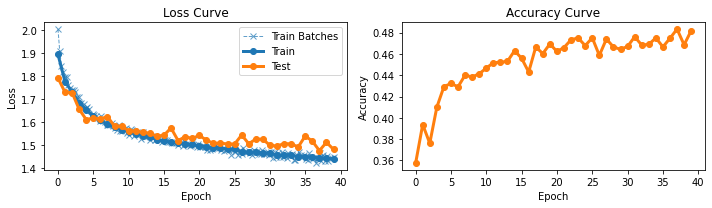

In [26]:
trainer.epochs = 40

trainer.train(use_gpu=USE_GPU)
trainer.plot()